<a href="https://colab.research.google.com/github/fellowship/deep-and-wide-bandit/blob/dev/generated_dataset4_csv_Aleksey_TF_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Imports

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import json
import pickle as pkl
import gc

%matplotlib inline
import matplotlib.pyplot as plt

import random
import seaborn as sns
from pprint import pprint
from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

#Makes panda and numpy easier to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(precision=3, suppress=True)

# Importing the Data

In [4]:
#Initialize a control variable that determines whether we will import data
reexport_var = False
project_folder = Path("/content/drive/MyDrive/Bandit_Project/generated_data_4_project")
train_path = project_folder/"train.csv"
val_path = project_folder/"val.csv"
test_path = project_folder/"test.csv"

In [5]:
if reexport_var:
  input_file = Path("/content/drive/MyDrive/Bandit_Project/BanditsData/generated4.csv")
  df = pd.read_csv(input_file, header=[0])

  #Subtract the optimal_action by 1 so as to make them compatible with tf.estimator
  df["optimal_action"] = df["optimal_action"] - 1
  df.head()

In [6]:
if reexport_var:
  #Splitting into training & test set - 60-20-20 split
  train_split_index = int(0.6 * len(df))
  val_split_index = int(0.8 * len(df))

  df_temp = df.copy()
  df_temp = df_temp.sample(frac=1, random_state=42).reset_index()

  train_df = df_temp.loc[:train_split_index, :]
  val_df = df_temp.loc[train_split_index:val_split_index, :]
  test_df = df_temp.loc[val_split_index:, :]

  #Printing the dataframes
  print(f"[INFO] The training dataframe has {len(train_df)} instances from indices {0} to {train_split_index-1}")
  train_df.head()
  print(f"[INFO] The validation dataframe has {len(val_df)} instances from indices {train_split_index} to {val_split_index - 1}")
  val_df.head()
  print(f"[INFO] The training dataframe has {len(test_df)} instances from indices {val_split_index} to {len(df)}")
  test_df.head()

  #Export training and test set into separate CSV files
  train_df.to_csv(train_path, index=False, header=True)
  val_df.to_csv(val_path, index=False, header=True)
  test_df.to_csv(test_path, index=False, header=True)

In [7]:
print(f"[INFO] Does training data exist? {train_path.exists()}")
print(f"[INFO] Does val data exist? {val_path.exists()}")
print(f"[INFO] Does test data exist? {test_path.exists()}")

[INFO] Does training data exist? True
[INFO] Does val data exist? True
[INFO] Does test data exist? True


# Preparing Dataset for evaluation

In [8]:
#Given a df patterns, convert them to DL
def df_to_dataloader(file_path, feature_columns, target, batch_size=32, shuffle=True):
  
  use_cols = feature_columns + [target]
  dataframe = pd.read_csv(file_path, usecols=use_cols)[use_cols]
  labels = dataframe.pop(target)
  labels = tf.one_hot(labels, depth=10)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  dl = ds.batch(batch_size)
  return dl

In [9]:
#Given CSV file patterns, convert them to DL
def csv_to_dataloader(file_pattern, feature_cols, target_col, shuffle=True, 
                       batch_size=1024, n_epochs = None):
  
  select_cols = feature_cols + [target_col]
  return tf.data.experimental.make_csv_dataset(file_pattern = file_pattern, 
                                             batch_size = batch_size,
                                             label_name = target_col,
                                             select_columns = select_cols,
                                             header=True, 
                                             num_epochs=n_epochs,
                                             shuffle=shuffle,  
                                             shuffle_seed=42,
                                             ignore_errors=True)

In [10]:
batch_size=2048
n_epochs=500

feature_columns = ["user_id", "user_feature_1", "user_feature_2", "campaign_id", 
"campaign_feature_1", "campaign_feature_2"]
target_column = "optimal_action"

train_dl = df_to_dataloader(train_path, feature_columns, target_column, batch_size=batch_size)
val_dl = df_to_dataloader(val_path, feature_columns, target_column, batch_size=batch_size)
test_dl = df_to_dataloader(test_path, feature_columns, target_column, shuffle = False, batch_size=batch_size)

#train_dl = csv_to_dataloader(str(train_path), feature_columns, target_column, batch_size=batch_size, n_epochs = n_epochs)
#val_dl = csv_to_dataloader(str(val_path), feature_columns, target_column, batch_size=batch_size, n_epochs = n_epochs)
#test_dl = csv_to_dataloader(str(test_path), feature_columns, target_column, shuffle = False, batch_size=batch_size, n_epochs = n_epochs)

print("[INFO] Train dataloader:")
pprint(train_dl)
print("[INFO] Val dataloader:")
pprint(val_dl)
print("[INFO] Test dataloader:")
pprint(test_dl)

[INFO] Train dataloader:
<BatchDataset shapes: ({user_id: (None,), user_feature_1: (None,), user_feature_2: (None,), campaign_id: (None,), campaign_feature_1: (None,), campaign_feature_2: (None,)}, (None, 10)), types: ({user_id: tf.int64, user_feature_1: tf.float64, user_feature_2: tf.float64, campaign_id: tf.int64, campaign_feature_1: tf.float64, campaign_feature_2: tf.float64}, tf.float32)>
[INFO] Val dataloader:
<BatchDataset shapes: ({user_id: (None,), user_feature_1: (None,), user_feature_2: (None,), campaign_id: (None,), campaign_feature_1: (None,), campaign_feature_2: (None,)}, (None, 10)), types: ({user_id: tf.int64, user_feature_1: tf.float64, user_feature_2: tf.float64, campaign_id: tf.int64, campaign_feature_1: tf.float64, campaign_feature_2: tf.float64}, tf.float32)>
[INFO] Test dataloader:
<BatchDataset shapes: ({user_id: (None,), user_feature_1: (None,), user_feature_2: (None,), campaign_id: (None,), campaign_feature_1: (None,), campaign_feature_2: (None,)}, (None, 10)), 

# Creating TF Feature Columns

## Numeric

In [11]:
#Initialize
numeric_feature_columns = []
numeric_feature_column_inputs = {}
numeric_df_col_names = ["user_feature_1", "user_feature_2", 
                        "campaign_feature_1", "campaign_feature_2"]

for col_name in numeric_df_col_names:
  tf_nfc = tf.feature_column.numeric_column(col_name)
  numeric_feature_columns.append(tf_nfc)
  numeric_feature_column_inputs[col_name] = tf.keras.Input(shape=(), name=col_name)

## Embedding



In [12]:
#Initialize
embedding_feature_columns = []
embedding_feature_column_inputs = {}

user_id = tf.feature_column.categorical_column_with_hash_bucket("user_id", hash_bucket_size=1000, dtype=tf.int64)
campaign_id = tf.feature_column.categorical_column_with_hash_bucket("campaign_id", hash_bucket_size=100, dtype=tf.int64)

user_id_embedding = tf.feature_column.embedding_column(user_id, dimension=16)
embedding_feature_columns.append(user_id_embedding)
embedding_feature_column_inputs["user_id"] = tf.keras.Input(shape=(), name="user_id", dtype=tf.int64)

campaign_id_embedding = tf.feature_column.embedding_column(campaign_id, dimension=7)
embedding_feature_columns.append(campaign_id_embedding)
embedding_feature_column_inputs["campaign_id"] = tf.keras.Input(shape=(), name="campaign_id", dtype=tf.int64)

## Crossed Columns

In [13]:
user_campaign_cross = tf.feature_column.crossed_column(["user_id", "campaign_id"], hash_bucket_size=100000)
user_campaign_cross_col = [tf.feature_column.indicator_column(user_campaign_cross)]

In [14]:
#Defining the inputs that will be fed to each model
#For W only —> numeric used as it is, categorical used in crosses
#For D only —> numeric used as it is, categorical used through embeddings
#For W&D —> numeric + categorical embedding IN deep, categorical crosses in Wide
inputs = {**numeric_feature_column_inputs, **embedding_feature_column_inputs}

# Models

In [15]:
#Results CSV file to save predictions from each of the models
results = pd.DataFrame()
result_csv_path = project_folder/"results.csv"

In [16]:
models_dir = project_folder/"models"
models_dir.mkdir(exist_ok=True)

#Create the folders to save the checkpoints
wmodel_dir = (models_dir/"Wide")
dmodel_dir = (models_dir/"Deep")
wdmodel_dir = (models_dir/"W&D")

wmodel_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for wide only model: {wmodel_dir.exists()}")
dmodel_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for deep only model: {dmodel_dir.exists()}")
wdmodel_dir.mkdir(exist_ok=True)
print(f"[INFO] Model folder created for wide + deep model: {wdmodel_dir.exists()}")

#Setting hyperparams
lr = 1e-3
gc.collect()

[INFO] Model folder created for wide only model: True
[INFO] Model folder created for deep only model: True
[INFO] Model folder created for wide + deep model: True


0

## Wide Only Model

In [39]:
wide_only_feature_columns = numeric_feature_columns + user_campaign_cross_col
wmodel_path = wmodel_dir/"wmodel.h5"
wmodel_checkpoint_path = wmodel_dir/"wmodel_checkpoint.h5"

#simple early stopping
w_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
w_mc = tf.keras.callbacks.ModelCheckpoint(str(wmodel_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Only Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_only_feature_columns, name="dense_feature_layer")(inputs)
w_linear_layer = tf.keras.layers.Dense(10, activation="softmax", name="wide_output")(w_feature_layer)
wmodel = tf.keras.Model(inputs = inputs, outputs=w_linear_layer)
wmodel.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
wmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
____________________________________________________________________________________________

In [40]:
H = wmodel.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[w_es, w_mc])

Epoch 1/500
2930/2930 [==============================] - 180s 59ms/step - loss: 2.1955 - accuracy: 0.2193 - auc_2: 0.6744 - val_loss: 2.0262 - val_accuracy: 0.3125 - val_auc_2: 0.7836

Epoch 00001: val_accuracy improved from -inf to 0.31246, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/Wide/wmodel_checkpoint.h5
Epoch 2/500
2930/2930 [==============================] - 179s 59ms/step - loss: 1.9761 - accuracy: 0.3323 - auc_2: 0.8014 - val_loss: 1.8893 - val_accuracy: 0.3271 - val_auc_2: 0.8128

Epoch 00002: val_accuracy improved from 0.31246 to 0.32706, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/Wide/wmodel_checkpoint.h5
Epoch 3/500
2930/2930 [==============================] - 179s 59ms/step - loss: 1.8446 - accuracy: 0.3450 - auc_2: 0.8261 - val_loss: 1.8040 - val_accuracy: 0.3315 - val_auc_2: 0.8227

Epoch 00003: val_accuracy improved from 0.32706 to 0.33151, saving model to /content/drive/MyDrive/Bandi

In [19]:
"""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use('ggplot')\nplt.plot(H.history['accuracy'], label='Training Accuracy')\nplt.plot(H.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(H.history['loss'], label='Training Loss')\nplt.plot(H.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.title('Accuracy/Loss vs Epochs')\nplt.xlabel('Epoch Number')\nplt.ylabel('Accuracy/Loss')\nplt.show()\n"

In [41]:
#Load the latest checkpoint
#wmodel = tf.keras.models.load_model(str(wmodel_checkpoint_path))

#Generate the predictions to a variable
wmodel_predictions = wmodel.predict(test_dl, batch_size=batch_size, verbose=1)
results["wide_only"] = np.argmax(wmodel_predictions, axis=1)

977/977 [==============================] - 31s 31ms/step


In [42]:
wmodel.save(str(wmodel_path))
del wmodel
del H
gc.collect()

110

## Deep Only Model

In [43]:
deep_only_feature_columns = numeric_feature_columns + embedding_feature_columns
deep_only_hidden_units = [512, 256, 128]
dmodel_path = dmodel_dir/"model.h5"
dmodel_checkpoint_path = dmodel_dir/"wmodel_checkpoint.h5"

#simple early stopping
d_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
d_mc = tf.keras.callbacks.ModelCheckpoint(str(dmodel_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Only Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_only_feature_columns, name="dense_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_only_hidden_units[0], activation="relu", name="fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_only_hidden_units[1], activation="relu", name="fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_only_hidden_units[2], activation="relu", name="fc_3")(d_hidden_layer_2)
d_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="deep_output")(d_hidden_layer_3)

dmodel = tf.keras.Model(inputs = inputs, outputs=d_output_layer)
dmodel.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
dmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
____________________________________________________________________________________________

In [44]:
H = dmodel.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[d_es, d_mc])

Epoch 1/500
2930/2930 [==============================] - 94s 30ms/step - loss: 0.9173 - accuracy: 0.6271 - auc_3: 0.9443 - val_loss: 0.5433 - val_accuracy: 0.7705 - val_auc_3: 0.9816

Epoch 00001: val_accuracy improved from -inf to 0.77052, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/Deep/wmodel_checkpoint.h5
Epoch 2/500
2930/2930 [==============================] - 94s 30ms/step - loss: 0.5326 - accuracy: 0.7754 - auc_3: 0.9823 - val_loss: 0.5043 - val_accuracy: 0.7847 - val_auc_3: 0.9841

Epoch 00002: val_accuracy improved from 0.77052 to 0.78471, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/Deep/wmodel_checkpoint.h5
Epoch 3/500
2930/2930 [==============================] - 94s 30ms/step - loss: 0.5051 - accuracy: 0.7839 - auc_3: 0.9840 - val_loss: 0.4957 - val_accuracy: 0.7855 - val_auc_3: 0.9846

Epoch 00003: val_accuracy improved from 0.78471 to 0.78546, saving model to /content/drive/MyDrive/Bandit_P

In [24]:
"""
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()
"""

"\n#Plot the training & validation loss/accuracy curve\nplt.figure()\nplt.style.use('ggplot')\nplt.plot(H.history['accuracy'], label='Training Accuracy')\nplt.plot(H.history['val_accuracy'], label='Validation Accuracy')\nplt.plot(H.history['loss'], label='Training Loss')\nplt.plot(H.history['val_loss'], label='Validation Loss')\nplt.legend()\nplt.title('Accuracy/Loss vs Epochs')\nplt.xlabel('Epoch Number')\nplt.ylabel('Accuracy/Loss')\nplt.show()\n"

In [45]:
#Generate the predictions to a variable
dmodel_predictions = dmodel.predict(test_dl, batch_size=batch_size, verbose=1)
results["deep_only"] = np.argmax(dmodel_predictions, axis=1)

977/977 [==============================] - 11s 11ms/step


In [46]:
dmodel.save(str(dmodel_path))
del dmodel
del H
gc.collect()

183

## Wide & Deep Model: 1

Wide part receives the crossed columns
Deep part receives the numeric features & embeddings

In [27]:
wide_wd_1_feature_columns = user_campaign_cross_col
deep_wd_1_feature_columns = numeric_feature_columns + embedding_feature_columns

deep_wd_1_hidden_units = [512, 256, 128]

wdmodel_1_path = wdmodel_dir/"wdmodel_1.h5"
wdmodel_1_checkpoint_path = wdmodel_dir/"wdmodel_1_checkpoint.h5"

#simple early stopping
wd_1_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
wd_1_mc = tf.keras.callbacks.ModelCheckpoint(str(wdmodel_1_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_1_feature_columns, name="wide_feature_layer")(inputs)

#Build the Deep Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_1_feature_columns, name="deep_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_1_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_1_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_wd_1_hidden_units[2], activation="relu", name="deep_fc_3")(d_hidden_layer_2)

#Combine the Wide & Deep
wd_1_both = tf.keras.layers.concatenate([w_feature_layer, d_hidden_layer_3])
wd_1_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="deep_output")(wd_1_both)

wd_1_model = tf.keras.Model(inputs = inputs, outputs=wd_1_output_layer)
wd_1_model.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
wd_1_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
______________________________________________________________________________________________

In [28]:
H = wd_1_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[wd_1_es, wd_1_mc])

Epoch 1/500
2930/2930 [==============================] - 189s 61ms/step - loss: 0.9502 - accuracy: 0.6163 - auc: 0.9389 - val_loss: 0.5515 - val_accuracy: 0.7741 - val_auc: 0.9811

Epoch 00001: val_accuracy improved from -inf to 0.77408, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/W&D/wdmodel_1_checkpoint.h5
Epoch 2/500
2930/2930 [==============================] - 186s 61ms/step - loss: 0.5383 - accuracy: 0.7785 - auc: 0.9819 - val_loss: 0.5139 - val_accuracy: 0.7841 - val_auc: 0.9835

Epoch 00002: val_accuracy improved from 0.77408 to 0.78410, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/W&D/wdmodel_1_checkpoint.h5
Epoch 3/500
2930/2930 [==============================] - 185s 61ms/step - loss: 0.5024 - accuracy: 0.7889 - auc: 0.9842 - val_loss: 0.5114 - val_accuracy: 0.7801 - val_auc: 0.9835

Epoch 00003: val_accuracy did not improve from 0.78410
Epoch 4/500
2930/2930 [==============================] - 

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Accuracy/Loss vs Epochs')

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Accuracy/Loss')

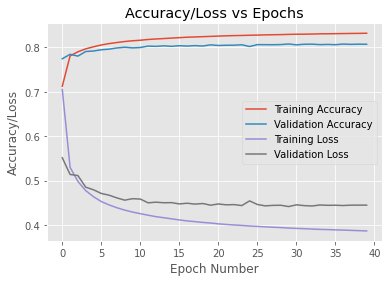

In [29]:
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()

In [30]:
#Generate the predictions to a variable
wd_1_predictions = wd_1_model.predict(test_dl, batch_size=batch_size, verbose=1)
results["wide_deep_1"] = np.argmax(wd_1_predictions, axis=1)

977/977 [==============================] - 28s 28ms/step


In [31]:
wd_1_model.save(str(wdmodel_1_path))
del wd_1_model
del H
gc.collect()

1926

## Wide & Deep Model 2

Wide part receives the crossed columns
Deep part receives the numeric features (No embeddings)

In [32]:
wide_wd_2_feature_columns = user_campaign_cross_col
deep_wd_2_feature_columns = numeric_feature_columns

deep_wd_2_hidden_units = [512, 256, 128]

wdmodel_2_path = wdmodel_dir/"wdmodel_2.h5"
wdmodel_2_checkpoint_path = wdmodel_dir/"wdmodel_2_checkpoint.h5"

#simple early stopping
wd_2_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
wd_2_mc = tf.keras.callbacks.ModelCheckpoint(str(wdmodel_2_checkpoint_path), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Build the Wide Model
w_feature_layer = tf.keras.layers.DenseFeatures(wide_wd_2_feature_columns, name="wide_feature_layer")(inputs)

#Build the Deep Model
d_feature_layer = tf.keras.layers.DenseFeatures(deep_wd_2_feature_columns, name="deep_feature_layer")(inputs)
d_hidden_layer_1 = tf.keras.layers.Dense(deep_wd_2_hidden_units[0], activation="relu", name="deep_fc_1")(d_feature_layer)
d_hidden_layer_2 = tf.keras.layers.Dense(deep_wd_2_hidden_units[1], activation="relu", name="deep_fc_2")(d_hidden_layer_1)
d_hidden_layer_3 = tf.keras.layers.Dense(deep_wd_2_hidden_units[2], activation="relu", name="deep_fc_3")(d_hidden_layer_2)

#Combine the Wide & Deep
wd_2_both = tf.keras.layers.concatenate([w_feature_layer, d_hidden_layer_3])
wd_2_output_layer = tf.keras.layers.Dense(10, activation="softmax", name="deep_output")(wd_2_both)

wd_2_model = tf.keras.Model(inputs = inputs, outputs=wd_2_output_layer)
wd_2_model.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', tf.keras.metrics.AUC()])
wd_2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
campaign_feature_1 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_feature_2 (InputLayer) [(None,)]            0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
user_feature_1 (InputLayer)     [(None,)]            0                                            
____________________________________________________________________________________________

In [33]:
H = wd_2_model.fit(train_dl, batch_size=batch_size, epochs=n_epochs, 
               validation_data=val_dl, shuffle=False, 
               validation_batch_size=batch_size, callbacks=[wd_2_es, wd_2_mc])

Epoch 1/500
2930/2930 [==============================] - 172s 56ms/step - loss: 0.9623 - accuracy: 0.6115 - auc_1: 0.9425 - val_loss: 0.7296 - val_accuracy: 0.6811 - val_auc_1: 0.9682

Epoch 00001: val_accuracy improved from -inf to 0.68111, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/W&D/wdmodel_2_checkpoint.h5
Epoch 2/500
2930/2930 [==============================] - 171s 56ms/step - loss: 0.7098 - accuracy: 0.6927 - auc_1: 0.9700 - val_loss: 0.7042 - val_accuracy: 0.6877 - val_auc_1: 0.9703

Epoch 00002: val_accuracy improved from 0.68111 to 0.68767, saving model to /content/drive/MyDrive/Bandit_Project/generated_data_4_project/models/W&D/wdmodel_2_checkpoint.h5
Epoch 3/500
2930/2930 [==============================] - 171s 56ms/step - loss: 0.6739 - accuracy: 0.7105 - auc_1: 0.9730 - val_loss: 0.6652 - val_accuracy: 0.7112 - val_auc_1: 0.9736

Epoch 00003: val_accuracy improved from 0.68767 to 0.71118, saving model to /content/drive/MyDrive/B

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Accuracy/Loss vs Epochs')

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Accuracy/Loss')

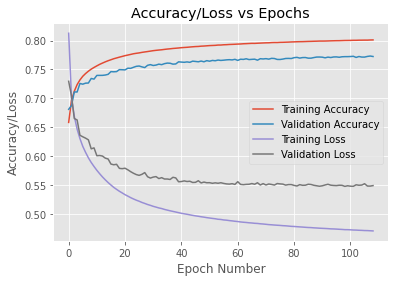

In [34]:
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()

In [35]:
#Generate the predictions to a variable
wd_2_predictions = wd_2_model.predict(test_dl, batch_size=batch_size, verbose=1)
results["wide_deep_2"] = np.argmax(wd_2_predictions, axis=1)

977/977 [==============================] - 26s 26ms/step


In [36]:
wd_2_model.save(str(wdmodel_2_path))
del wd_2_model
del H
gc.collect()

110

# Saving prediction results 

In [49]:
results.to_csv(result_csv_path, header=True, index=False)
results.head()

,wide_deep_1,wide_deep_2,wide_only,deep_only,target
0,4,4,4,4,4
1,1,2,2,4,0
2,4,4,5,4,4
3,2,2,2,2,2
4,9,9,4,9,9


In [52]:
for model_type in ["wide_only", "deep_only", "wide_deep_1", "wide_deep_2"]:
  acc = ((results[model_type] == results["target"]).astype(int).sum())/len(results)
  print(f"[INFO] {model_type} accuracy: {acc}")

[INFO] wide_only accuracy: 0.3360835
[INFO] deep_only accuracy: 0.807614
[INFO] wide_deep_1 accuracy: 0.806596
[INFO] wide_deep_2 accuracy: 0.772791
